In [1]:
##IMPORT LIBRARIES 
import pyreadr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from statsmodels.formula.api import ols
import statsmodels.api as sm
from src.post_hoc import apply_tukey, plot_tukey

In [2]:
#READ RDS FILES
agg_data = pyreadr.read_r('./data/raw/BW_tshedimoso_TSI.RDS')
phylo_features = pyreadr.read_r("./data/raw/BW_tshedimoso_phylo_patstats.RDS")
maf_data = pyreadr.read_r("./data/raw/Cleaned_BW_tshedimoso_MAFs.RDS")

#ACCESS DATAFRAMES
agg_data_df = agg_data[None]
phylo_features_df = phylo_features[None]
maf_data_df = maf_data[None]

# BOX PLOT - CD4 Count and Viral Load
- required - agg_data_df

In [3]:
intervals = [
    agg_data_df['TSI_days'] <= 120,
    (agg_data_df['TSI_days'] > 120) & (agg_data_df['TSI_days'] <= 240),
    (agg_data_df['TSI_days'] > 240) & (agg_data_df['TSI_days'] <= 365),
    agg_data_df['TSI_days'] > 365
]
categories = ['0-4', '4-8', '8-12', '12+']
agg_data_df['TSI_category'] = np.select(intervals, categories, default=np.nan)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 6.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


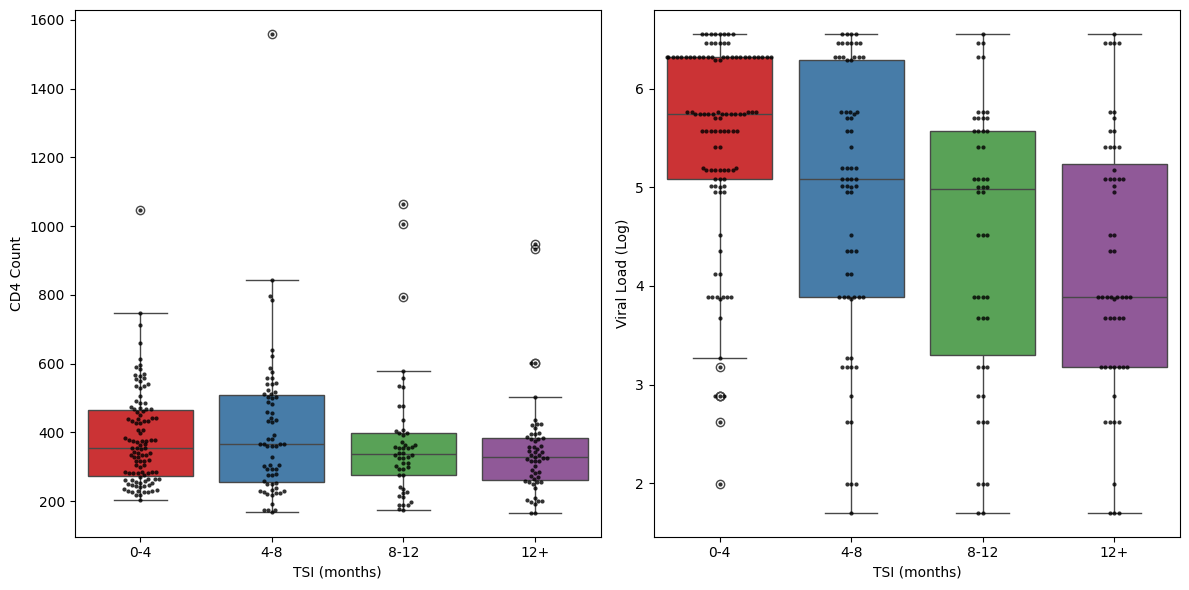

In [4]:
plt.figure(figsize=(12, 6))

#CD4 Count
plt.subplot(1, 2, 1) 
sns.boxplot(x='TSI_category', y='cd4', data = agg_data_df, hue='TSI_category', palette='Set1')
plt.xlabel('TSI (months)')
plt.ylabel('CD4 Count')

sns.swarmplot(x='TSI_category', y='cd4', data=agg_data_df, color='k', alpha=0.8, size=3)

#Log Viral Load
plt.subplot(1, 2, 2) 
sns.boxplot(x='TSI_category', y='log10VL_bl', data = agg_data_df, hue='TSI_category', palette='Set1')
plt.xlabel('TSI (months)')
plt.ylabel('Viral Load (Log)')
sns.swarmplot(x='TSI_category', y='log10VL_bl', data=agg_data_df, color='k', alpha=0.8, size=3)
plt.tight_layout()
plt.show()


## ANOVA

In [4]:
cd4_anova_model = ols('cd4 ~ C(TSI_category)', data=agg_data_df).fit() 
cd4_anova_table = sm.stats.anova_lm(cd4_anova_model, typ=2)

vl_anova_model = ols('log10VL_bl ~ C(TSI_category)', data=agg_data_df).fit() 
vl_anova_table = sm.stats.anova_lm(vl_anova_model, typ=2)

In [5]:
#POST HOC TEST on VIRAL LOAD 
tukey_results_vl = apply_tukey(feature= 'log10VL_bl', anova_table= vl_anova_table, population = 'TSI_category', df = agg_data_df)
tukey_results_cd4 = apply_tukey(feature= 'cd4', anova_table= cd4_anova_table, population = 'TSI_category', df = agg_data_df)

/Users/andreawickman/saving_lives/src/post_hoc.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_table['PR(>F)'][0] < 0.05:


Significant ANOVA result, proceed with post-hoc testing.
No significant differences found by ANOVA.


## Tukey Plot

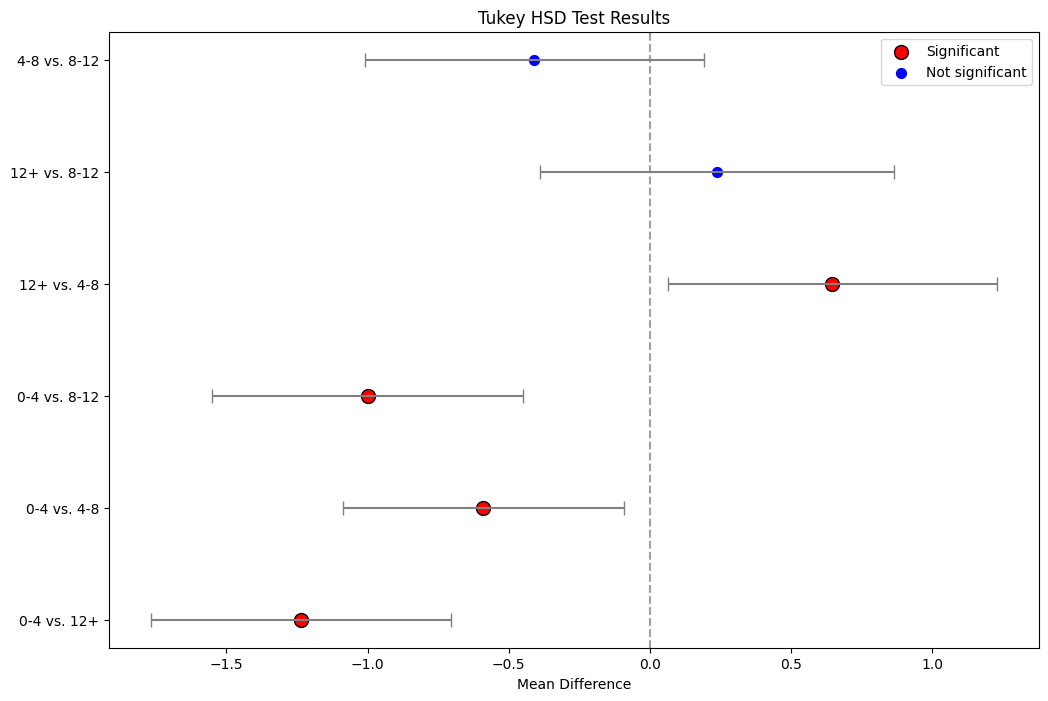

In [6]:
plot_tukey(tukey_results_vl)

# ART

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in equal
  return op(a, b)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in equal
  return op(a, b)


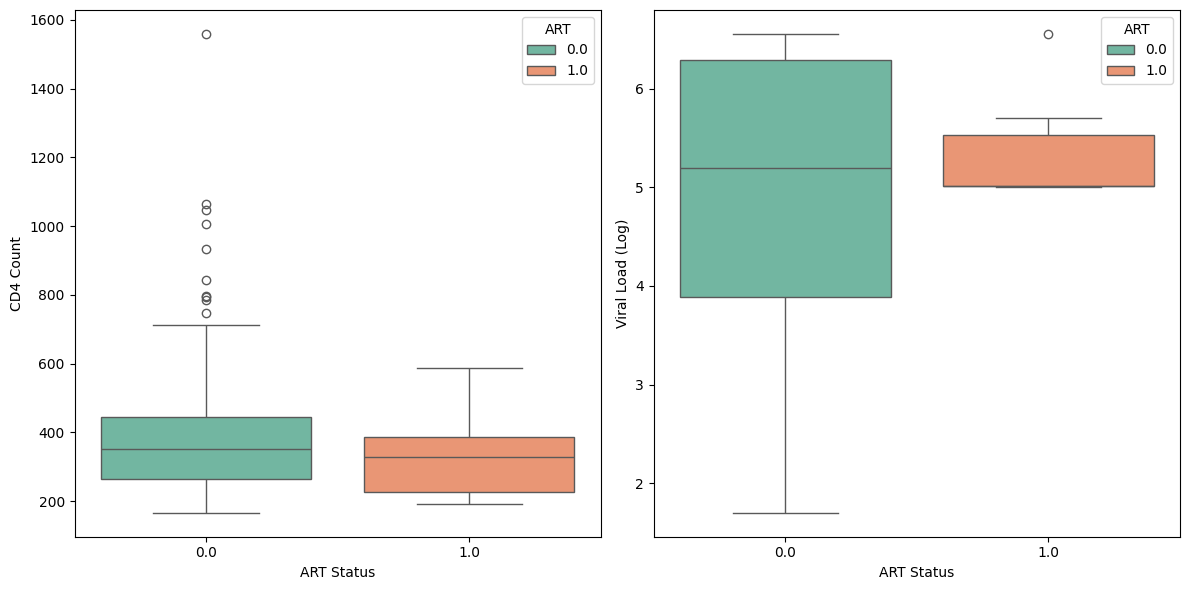

In [9]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1) 
sns.boxplot(x='ART', y='cd4', data = agg_data_df, hue='ART', palette='Set2')
plt.xlabel('ART Status')
plt.ylabel('CD4 Count')

plt.subplot(1, 2, 2) 
sns.boxplot(x='ART', y='log10VL_bl', data = agg_data_df, hue='ART', palette='Set2')
plt.xlabel('ART Status')
plt.ylabel('Viral Load (Log)')
plt.tight_layout()
plt.show()

In [38]:
agg_data_df['ART'].value_counts()

ART
0.0    264
1.0      6
Name: count, dtype: int64

In [11]:
group0 = agg_data_df[agg_data_df['ART'] == 0.0]['cd4'].dropna()
group1 = agg_data_df[agg_data_df['ART'] == 1.0]['cd4'].dropna()

t_stat, p_value = ttest_ind(group0, group1, equal_var=False)
print(f"Welch's t-test results -- t-statistic: {t_stat:.3f}, p-value: {p_value:.3f}")

group0 = agg_data_df[agg_data_df['ART'] == 0.0]['log10VL_bl'].dropna()
group1 = agg_data_df[agg_data_df['ART'] == 1.0]['log10VL_bl'].dropna()

t_stat, p_value = ttest_ind(group0, group1, equal_var=False)
print(f"Welch's t-test results -- t-statistic: {t_stat:.3f}, p-value: {p_value:.3f}")

Welch's t-test results -- t-statistic: 0.705, p-value: 0.511
Welch's t-test results -- t-statistic: -1.664, p-value: 0.147


no significant difference present in biomarkers for ART taken or not.

## Multiple Infection

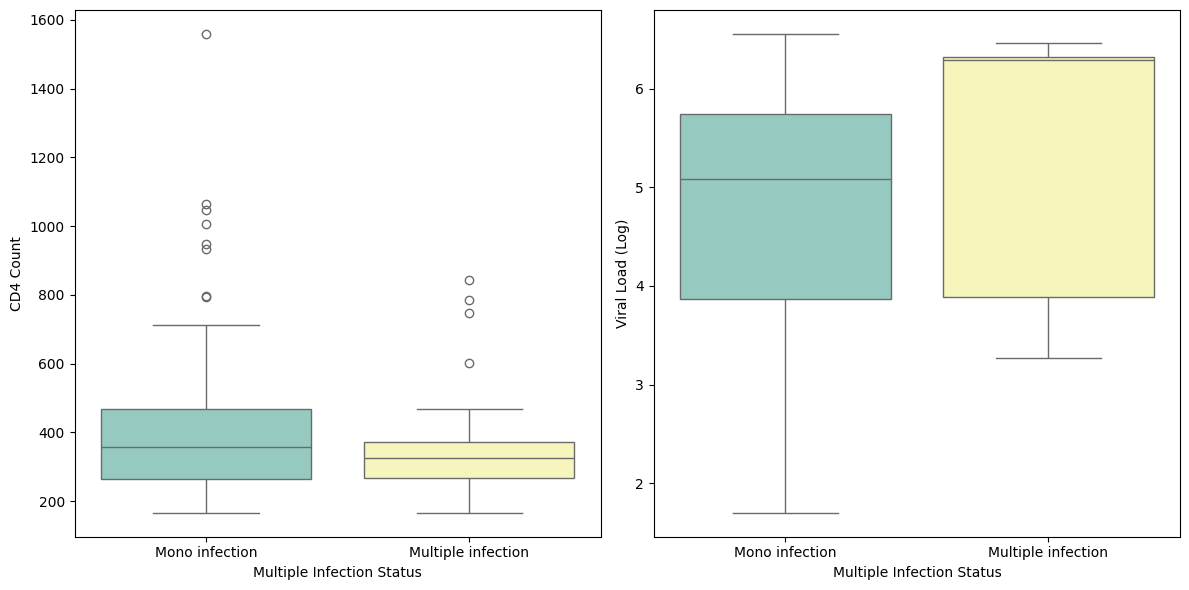

multiple_inf
Mono infection        229
Multiple infection     53
Name: count, dtype: int64

In [22]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1) 
sns.boxplot(x='multiple_inf', y='cd4', data = agg_data_df, hue='multiple_inf', palette='Set3')
plt.xlabel('Multiple Infection Status')
plt.ylabel('CD4 Count')

plt.subplot(1, 2, 2) 
sns.boxplot(x='multiple_inf', y='log10VL_bl', data = agg_data_df, hue='multiple_inf', palette='Set3')
plt.xlabel('Multiple Infection Status')
plt.ylabel('Viral Load (Log)')
plt.tight_layout()
plt.show()

agg_data_df['multiple_inf'].value_counts()

In [21]:
group_mono = agg_data_df[agg_data_df['multiple_inf'] == 'Mono infection']['cd4'].dropna()
group_mult = agg_data_df[agg_data_df['multiple_inf'] == 'Multiple infection']['cd4'].dropna()

t_stat, p_value = ttest_ind(group_mono, group_mult, equal_var=False)
print(f"Welch's t-test results -- t-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")

group_mono_vl = agg_data_df[agg_data_df['multiple_inf'] == 'Mono infection']['log10VL_bl'].dropna()
group_mult_vl = agg_data_df[agg_data_df['multiple_inf'] == 'Multiple infection']['log10VL_bl'].dropna()

t_stat, p_value = ttest_ind(group_mono_vl, group_mult_vl, equal_var=False)
print(f"Welch's t-test results -- t-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")

Welch's t-test results -- t-statistic: 1.7441, p-value: 0.0846
Welch's t-test results -- t-statistic: -3.8783, p-value: 0.0002
